## Image Captioning - Pretrained Resnet50 with Attention

In [2]:
import os
from pathlib import Path
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
from collections import Counter
import sys


#PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

#Vision
import torchvision.transforms as T
import torchvision.models as models

#Torchtext
import torchtext; torchtext.disable_torchtext_deprecation_warning() #supress warning
from torchtext.vocab import vocab
#from torchtext.data.utils import get_tokenizer


Mapping google drive and extracting zip file

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# with zipfile.ZipFile('/content/drive/MyDrive/archive.zip') as z_temp:
#     z_temp.extractall()

In [4]:
#Run if needed
# with zipfile.ZipFile('data/archive.zip') as z_temp:
#     z_temp.extractall(path='data/')

Check path to the image files and caption file:

In [5]:
current_dir = Path.cwd()

if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    project_root = current_dir

if project_root not in sys.path:
    sys.path.append(str(project_root))

captions_path = project_root / 'data' / 'flickr30k_images' / 'results.csv'
image_dir = project_root  / 'data' / 'flickr30k_images' / 'flickr30k_images'
image_paths = list(image_dir.glob('*.jpg'))

if captions_path.exists():
    print("Caption path exists")
else:
    print("Caption path does not exist")

if image_dir.exists() and image_dir.is_dir():
    print("Image directory exists")
    
    if image_paths:
        print(f"Found {len(image_paths)} images in the directory.")
    else:
        print("No images found in the directory.")
else:
    print("Image directory does not exist")


Caption path exists
Image directory exists
Found 31783 images in the directory.


Check caption.txt file and get the random raws (7 samples) from it

In [6]:
image_captions = pd.read_csv(captions_path, sep='|')
image_captions.columns = image_captions.columns.str.strip()
image_captions.sample(7)

,image_name,comment_number,comment
21426,2236895638.jpg,1,A person in white with a black hat on trying ...
135654,5506385451.jpg,4,A young girl floating in a basin in a body of...
131043,5108562132.jpg,3,Brunette woman is signing while playing a pia...
76999,3572267708.jpg,4,Girls dance in colorful outfits .
43389,278368851.jpg,4,People in a subway waiting for their train .
89758,3992000353.jpg,3,"Three women against a window , cleaning the g..."
128468,4967237527.jpg,3,Two young men wearing camouflage stand in the...


In [7]:
image_captions.shape

(158915, 3)

As we can see our caption file is the size of (158915, 3):

**image_name:** This is for filenames of the images, such as 3756150099.jpg, 4014757090.jpg, etc. Each file related to a unique image in the dataset.

**comment_number:** This column is an identifier for the caption related with each image. Since each image in flickr30k might have multiple captions, comment_number distinguishes between them (e.g., 0, 1, 2, etc.).

**comment:** This column is for the actual caption text describing the content of the image.

In [8]:
#Handeling device selection
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Using en_core_web_lg to built vocabulary for our captions. WE are also adding special tokens UNK_TOKEN = 'unk', PAD_TOKEN = 'pad', SOS_TOKEN = 'sos', EOS_TOKEN = 'eos' to our vocabulary:

In [9]:
from src.vocab_builder import VocabularyBuilder

#Replace non-string values with empty string
image_captions['comment'] = image_captions['comment'].apply(lambda x: x if isinstance(x, str) else '')
text_lines = image_captions['comment'].tolist()

#Uncomment or comment if you want to load or build/save
vocab_builder = VocabularyBuilder(min_freq=2, save_path='saved_model/vocab.pth', special_token=True)
#vocab = vocab_builder.build_vocab(text_lines)
vocab = vocab_builder.load_vocab(device)


In [10]:
words = vocab.get_itos()
print("Words in our vocab:", words)

vocab_length = len(vocab)
print(f"Total number of words in vocab: {vocab_length}")

Words in our vocab: ['<unk>', '<pad>', '<sos>', '<eos>', 'two', 'young', 'guy', 'with', 'shaggy', 'hair', 'look', 'at', 'their', 'hand', 'while', 'hang', 'out', 'in', 'the', 'yard', 'white', 'male', 'be', 'outside', 'near', 'many', 'bush', 'man', 'green', 'shirt', 'stand', 'a', 'blue', 'garden', 'friend', 'enjoy', 'time', 'spend', 'together', 'several', 'hard', 'hat', 'operate', 'giant', 'pulley', 'system', 'worker', 'down', 'from', 'up', 'above', 'on', 'piece', 'of', 'equipment', 'work', 'machine', 'wear', 'four', 'top', 'tall', 'structure', 'three', 'large', 'rig', 'child', 'pink', 'dress', 'climb', 'set', 'stair', 'an', 'entry', 'way', 'little', 'girl', 'go', 'into', 'wooden', 'cabin', 'to', 'her', 'playhouse', 'building', 'someone', 'and', 'lean', 'against', 'window', 'ladder', 'clean', 'jean', 'cleaning', 'one', 'gray', 'black', 'stove', 'cook', 'joke', 'around', 'camera', 'kitchen', 'food', 'prepare', 'meal', 'people', 'photo', 'play', 'guitar', 'other', 'poke', 'he', 'hold', 'ob

Creating our dataset instance:

In [11]:
from src.image_caption_dataset import ImageCaptionDataset

# transforms = T.Compose([
#     T.Resize(226),                     
#     T.RandomCrop(224),                 
#     T.ToTensor(),                               
#     T.Normalize((1, 1, 1), (1, 1, 1))
# ])
transforms = T.Compose([
            T.Resize((224, 224)),  #Resize to fixed size
            T.ToTensor()
        ])


flickr_dataset =  ImageCaptionDataset(
    image_paths = image_paths,
    captions = captions_path,
    vocabulary_builder=vocab_builder,
    transform = transforms
)

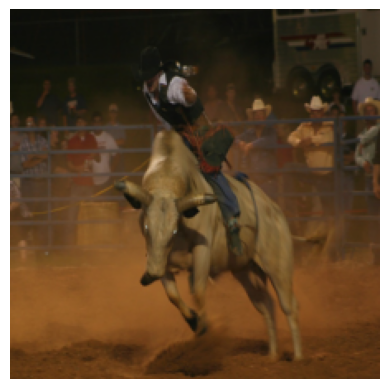

tensor([   2,   31,   27,   22,   22,  747,   48,   18, 3370,  111,   22,  473,
         621,   31, 2916,    3])
Caption :
<sos> a man be be throw from the bull he be ride during a rodeo <eos>


In [12]:
from src.utils import display_image
img, ids = flickr_dataset[10366]
display_image(img)
print(ids)
print('Caption :')
print(vocab_builder.token_ids_to_caption(ids))

Defining dataloader for our dataset:

In [13]:
from src.batch_caption_collator import BatchCaptionCollator

pad_idx = vocab_builder.vocabulary['<pad>']
batch_size = 128
num_workers = 4

collator = BatchCaptionCollator(pad_idx=pad_idx, batch_first=True)


data_loader = DataLoader(
    dataset=flickr_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collator,
    num_workers=num_workers 
)


Now it is time to define our model and hyperparameter:

In [14]:
vocab_size = len(vocab_builder.vocabulary)

emb_size = 300
attn_size = 256

enc_hidden_size = 2048
dec_hidden_size = 512

learning_rate = 3e-4

In [15]:
from src.models.encoderdecoder import EncoderDecoder

model = EncoderDecoder(
    emb_size,
    vocab_size,
    attn_size,
    enc_hidden_size,
    dec_hidden_size 
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
num_epochs = 10
print_every = 100

for epoch in range(1, num_epochs + 1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):

        image, captions = image.to(device), captions.to(device)

        optimizer.zero_grad()

        outputs, attentions = model(image, captions)#Forward pass

        targets = captions[:, 1:] #Remove first token to get target sequence

        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        loss.backward() #backward pass
        optimizer.step()
        

        if (idx + 1) % print_every == 0:
            print('Epoch: {} loss: {:.5f}'.format(epoch,loss.item()))

            model.eval()
            with torch.no_grad():
                img, _ = next(iter(data_loader))

                features = model.encoder(img[0:1].to(device))
                caps, attn_weights = model.decoder.generate_caption(features, vocab=flickr_dataset.vocabulary_builder.vocabulary)

                caption = ' '.join(caps)
                display_image(img[0], caption = caption)
                
            model.train()

Epoch: 1 loss: 4.81895


TypeError: display_image() got an unexpected keyword argument 'title'